# **PROYECTO: Clasificación de Frutas por Color - SERVIDOR PYTHON / Cliente ESP32-S3**

   Autor: David Arias, Keneth Montiel



# **Objetivo**
Diseñar un sistema inteligente distribuido donde la "inteligencia" está en el servidor (red neuronal) y que la distribución se refiere a múltiples microcontroladores como clientes.

# 1. **Diagrama de la arquitectura de la solución.**

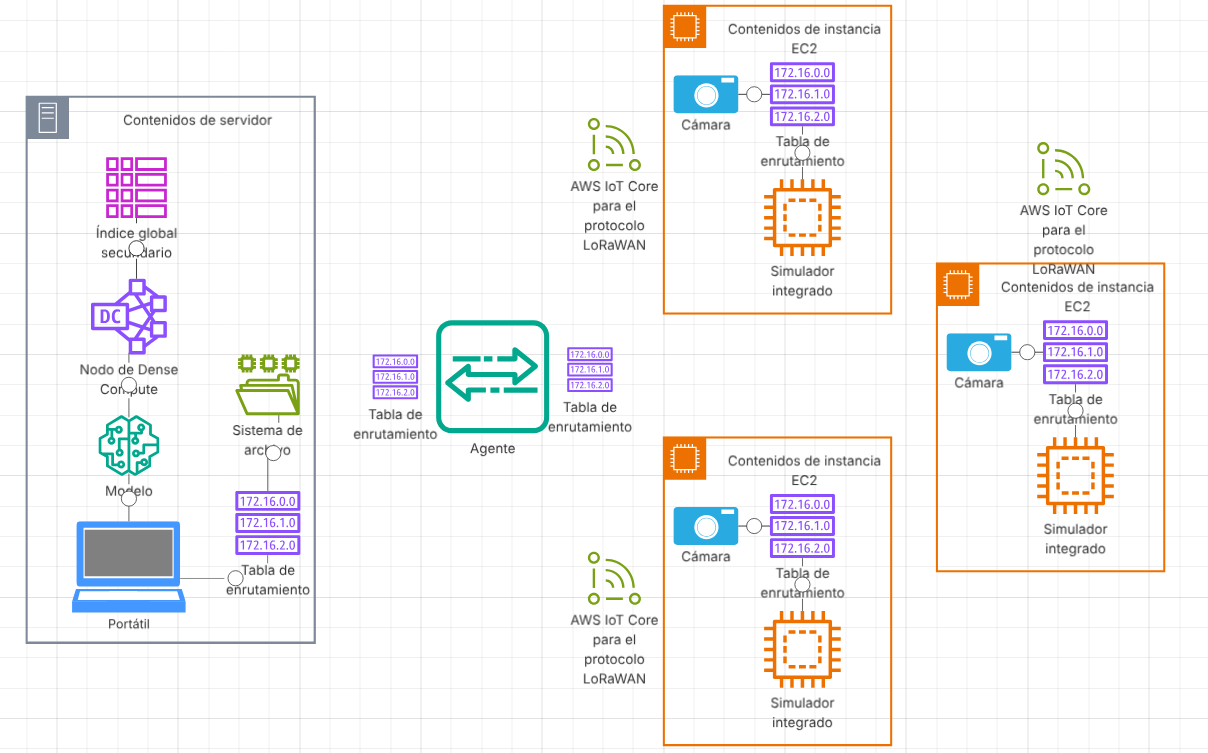



# 2.  **Dos código del microcontrolador en dos lenguajes diferentes.LENGUAJE ARDUINO/ESP32**



```
/* ===========================================================
   🟢 PROYECTO: Clasificación de Frutas por Color - Cliente ESP32-S3 ARDUINO/ESP32
   Autor: David Arias, Keneth Montiel
   Descripción:
   Este código permite a un ESP32-S3 funcionar como un cliente IoT que:
   - Lee el color de una fruta usando un sensor TCS34725.
   - Envía los valores RGB a un servidor Flask por medio de HTTP POST.
   - Recibe la clasificación del servidor (Manzana, Limón o Banana).
   - Enciende un LED correspondiente a la fruta detectada.
   - Imprime en el monitor serial el resultado de la inferencia.
   =========================================================== */

#include <WiFi.h>
#include <HTTPClient.h>
#include <Wire.h>
#include "Adafruit_TCS34725.h"

// ======= CONFIGURACIÓN Wi-Fi =======
const char* SSID = "WIFI_DAVID";            // Nombre de la red WiFi
const char* PASS = "Camila2000";            // Contraseña del WiFi
const char* SERVER_URL = "http://192.168.101.74:5000/infer"; // URL del servidor Flask
// ===================================

// ======= CONFIGURACIÓN DE PINES =======
#define SDA_PIN 8          // Pin SDA del sensor de color
#define SCL_PIN 9          // Pin SCL del sensor de color
#define BUTTON_PIN 15      // Botón para tomar lectura
#define LED_RED 4          // LED para "Manzana"
#define LED_GREEN 5        // LED para "Limón"
#define LED_YELLOW 6       // LED para "Banana"
// ======================================

// ======= SENSOR TCS34725 =======
// Configuración del sensor de color (integración y ganancia)
Adafruit_TCS34725 tcs = Adafruit_TCS34725(
  TCS34725_INTEGRATIONTIME_154MS,
  TCS34725_GAIN_4X
);
// ======================================

// ======= PARÁMETROS DE CONTROL =======
unsigned long lastButtonMillis = 0;   // Control de rebote del botón
const unsigned long debounceMs = 100;
const int MAX_RETRIES = 3;            // Intentos de reenvío en caso de fallo
const int RETRY_DELAY_MS = 500;       // Tiempo entre reintentos
// ======================================

// ======= VARIABLES GLOBALES =======
String deviceID = "";  // Almacena la MAC del ESP32 (ID único del cliente)
// ======================================

// ---------- FUNCIÓN: Obtener la MAC ----------
String getMacAddress() {
  return WiFi.macAddress();
}

// ---------- FUNCIÓN: Controlar LEDs según la clasificación ----------
void setLeds(String label) {
  digitalWrite(LED_RED, LOW);
  digitalWrite(LED_GREEN, LOW);
  digitalWrite(LED_YELLOW, LOW);

  // Enciende el LED correspondiente a la fruta detectada
  if (label == "Manzana") digitalWrite(LED_RED, HIGH);
  else if (label == "Limon") digitalWrite(LED_GREEN, HIGH);
  else if (label == "Banana" ) digitalWrite(LED_YELLOW, HIGH);
  else digitalWrite(LED_YELLOW, HIGH); // En caso de error o clase desconocida
}

// ---------- SETUP ----------
void setup() {
  Serial.begin(115200);
  delay(500);

  // Inicializar pines
  pinMode(BUTTON_PIN, INPUT_PULLUP);
  pinMode(LED_RED, OUTPUT);
  pinMode(LED_GREEN, OUTPUT);
  pinMode(LED_YELLOW, OUTPUT);
  setLeds("none"); // Apagar LEDs al iniciar

  // Iniciar bus I2C
  Wire.begin(SDA_PIN, SCL_PIN);
  delay(100);

  // Inicializar el sensor de color
  if (!tcs.begin()) {
    Serial.println("❌ ERROR: No se detectó el sensor TCS34725. Verifica SDA/SCL o alimentación.");
    while (true) delay(1000);
  }
  Serial.println("✅ Sensor TCS34725 detectado correctamente.");

  // Conectar al WiFi
  WiFi.begin(SSID, PASS);
  Serial.print("🔗 Conectando a WiFi");
  unsigned long start = millis();

  while (WiFi.status() != WL_CONNECTED) {
    delay(300);
    Serial.print(".");
    if (millis() - start > 15000) {
      Serial.println("\n⚠️ Falló la conexión Wi-Fi. Verifica credenciales o reinicia el ESP32.");
      break;
    }
  }

  if (WiFi.status() == WL_CONNECTED) {
    Serial.println("\n✅ Wi-Fi conectado.");
    Serial.print("IP local: ");
    Serial.println(WiFi.localIP());

    // Guardar la dirección MAC como ID único
    deviceID = WiFi.macAddress();
    Serial.print("Device ID (MAC): ");
    Serial.println(deviceID);
  }

  Serial.println("\n📤 Presiona el botón para tomar y enviar una lectura.");
}

// ---------- FUNCIÓN: Lectura de color ----------
void readColor(float &r, float &g, float &b) {
  uint16_t rr, gg, bb, c;
  tcs.getRawData(&rr, &gg, &bb, &c);
  if (c == 0) c = 1; // Evitar división por cero
  r = (float)rr / (float)c * 255.0;
  g = (float)gg / (float)c * 255.0;
  b = (float)bb / (float)c * 255.0;
}

// ---------- FUNCIÓN: Enviar datos al servidor ----------
bool sendToServer(const String &mac, float r, float g, float b, String &outLabel, float &outScore) {
  // Si se pierde la conexión WiFi, intenta reconectar
  if (WiFi.status() != WL_CONNECTED) {
    Serial.println("🔁 WiFi desconectado, intentando reconectar...");
    WiFi.reconnect();
    delay(500);
    if (WiFi.status() != WL_CONNECTED) return false;
  }

  HTTPClient http;
  http.begin(SERVER_URL);
  http.addHeader("Content-Type", "application/json");

  // Se envían los datos RGB junto con el ID único del cliente
  String payload = "{\"id\":\"" + mac + "\",\"rgb\":[" + String(r,2) + "," + String(g,2) + "," + String(b,2) + "]}";
  int httpCode = http.POST(payload);

  // Procesar respuesta del servidor
  if (httpCode > 0) {
    String resp = http.getString();
    Serial.printf("🌐 HTTP %d -> %s\n", httpCode, resp.c_str());

    // Parsear respuesta sin librerías extra
    int s = resp.indexOf("\"class\":\"");
    int e = resp.indexOf("\"", s + 9);
    outLabel = (s >= 0 && e > s) ? resp.substring(s + 9, e) : "unknown";

    int sp = resp.indexOf("\"score\":");
    if (sp >= 0) {
      String sc = resp.substring(sp + 8);
      sc.replace("}", "");
      outScore = sc.toFloat();
    } else outScore = 0.0;

    http.end();
    return true;
  } else {
    Serial.printf("❌ Error POST: %d\n", httpCode);
    http.end();
    return false;
  }
}

// ---------- LOOP PRINCIPAL ----------
void loop() {
  // Detectar si se presiona el botón (activo en LOW)
  if (digitalRead(BUTTON_PIN) == LOW) {
    if (millis() - lastButtonMillis < debounceMs) return;
    lastButtonMillis = millis();

    float r, g, b;
    readColor(r, g, b);

    // Mostrar la lectura por el monitor serial
    Serial.println("\n---- Nueva Lectura ----");
    Serial.print("Device ID (MAC): ");
    Serial.println(deviceID);
    Serial.printf("🎨 RGB -> R: %.2f  G: %.2f  B: %.2f\n", r, g, b);

    String label = "none";
    float score = 0.0;
    bool ok = false;

    // Enviar la lectura al servidor (con reintentos)
    for (int i = 0; i < MAX_RETRIES; i++) {
      if (sendToServer(deviceID, r, g, b, label, score)) { ok = true; break; }
      Serial.printf("🔁 Reintentando envío... (%d)\n", i + 1);
      delay(RETRY_DELAY_MS * (i + 1));
    }

    // Mostrar resultado y encender LED correspondiente
    if (ok) {
      Serial.printf("✅ Clasificación: %s (score=%.3f)\n", label.c_str(), score);
      setLeds(label);
    } else {
      Serial.println("⚠️ No se logró contactar el servidor.");
      setLeds("unknown");
    }

    Serial.println("------------------------\n");
    while (digitalRead(BUTTON_PIN) == LOW) delay(20); // Espera liberar botón
  }

  delay(50);
}

```





# 2.  **Dos código del microcontrolador en dos lenguajes diferentes. LENGUAJE C**



```
/* ===========================================================
   🟢 PROYECTO: Clasificación de Frutas por Color - Cliente ESP32-S3  Lenguaje C
   Autor: David Arias, Keneth Montiel
   Descripción:
   Este código permite a un ESP32 funcionar como un cliente IoT que:
   - Lee el color de una fruta usando un sensor TCS34725.
   - Envía los valores RGB a un servidor Flask por HTTP POST.
   - Recibe la clasificación del servidor (Manzana, Limon o Banana).
   - Enciende un LED correspondiente a la fruta detectada.
   - Imprime en el monitor serial el resultado de la inferencia.
   =========================================================== */

#include <WiFi.h>
#include <HTTPClient.h>
#include <Wire.h>
#include "Adafruit_TCS34725.h"

// ======= CONFIGURACIÓN Wi-Fi =======
const char* SSID = "WIFI_DAVID";                     // Nombre de la red WiFi
const char* PASS = "Camila2000";                     // Contraseña del WiFi
const char* SERVER_URL = "http://192.168.101.74:5000/infer"; // URL del servidor Flask
// ===================================

// ======= CONFIGURACIÓN DE PINES =======
#define SDA_PIN 8          // Pin SDA del sensor de color
#define SCL_PIN 9          // Pin SCL del sensor de color
#define BUTTON_PIN 15       // Botón para tomar lectura
#define LED_RED 4           // LED para "Manzana"
#define LED_GREEN 5         // LED para "Limon"
#define LED_YELLOW 6        // LED para "Banana"
// ======================================

// ======= SENSOR TCS34725 =======
Adafruit_TCS34725 tcs = Adafruit_TCS34725(
  TCS34725_INTEGRATIONTIME_154MS,
  TCS34725_GAIN_4X
);
// ======================================

// ======= PARÁMETROS DE CONTROL =======
unsigned long lastButtonMillis = 0;  
const unsigned long debounceMs = 100;
const int MAX_RETRIES = 3;          
const int RETRY_DELAY_MS = 500;     
// ======================================

// ======= VARIABLES GLOBALES =======
String deviceID = "";  // MAC del ESP32
// ======================================

// ---------- FUNCIÓN: Obtener la MAC ----------
String getMacAddress() {
  return WiFi.macAddress();
}

// ---------- FUNCIÓN: Controlar LEDs según la clasificación ----------
void setLeds(String label) {
  digitalWrite(LED_RED, LOW);
  digitalWrite(LED_GREEN, LOW);
  digitalWrite(LED_YELLOW, LOW);

  if (label == "Manzana") digitalWrite(LED_RED, HIGH);
  else if (label == "Limon") digitalWrite(LED_GREEN, HIGH);
  else if (label == "Banana") digitalWrite(LED_YELLOW, HIGH);
  else digitalWrite(LED_YELLOW, HIGH); // Por defecto
}

// ---------- FUNCIÓN: Lectura de color ----------
void readColor(float &r, float &g, float &b) {
  uint16_t rr, gg, bb, c;
  tcs.getRawData(&rr, &gg, &bb, &c);
  if (c == 0) c = 1;
  r = (float)rr / (float)c * 255.0;
  g = (float)gg / (float)c * 255.0;
  b = (float)bb / (float)c * 255.0;
}

// ---------- FUNCIÓN: Enviar datos al servidor ----------
bool sendToServer(const String &mac, float r, float g, float b, String &outLabel, float &outScore) {
  if (WiFi.status() != WL_CONNECTED) {
    WiFi.reconnect();
    delay(500);
    if (WiFi.status() != WL_CONNECTED) return false;
  }

  HTTPClient http;
  http.begin(SERVER_URL);
  http.addHeader("Content-Type", "application/json");

  String payload = "{\"id\":\"" + mac + "\",\"rgb\":[" + String(r,2) + "," + String(g,2) + "," + String(b,2) + "]}";
  int httpCode = http.POST(payload);

  if (httpCode > 0) {
    String resp = http.getString();

    // Parsear JSON simple
    int s = resp.indexOf("\"class\":\"");
    int e = resp.indexOf("\"", s + 9);
    outLabel = (s >= 0 && e > s) ? resp.substring(s + 9, e) : "unknown";

    int sp = resp.indexOf("\"score\":");
    if (sp >= 0) {
      String sc = resp.substring(sp + 8);
      sc.replace("}", "");
      outScore = sc.toFloat();
    } else outScore = 0.0;

    http.end();
    return true;
  } else {
    http.end();
    return false;
  }
}

// ---------- SETUP ----------
void setup() {
  Serial.begin(115200);
  delay(500);

  pinMode(BUTTON_PIN, INPUT_PULLUP);
  pinMode(LED_RED, OUTPUT);
  pinMode(LED_GREEN, OUTPUT);
  pinMode(LED_YELLOW, OUTPUT);
  setLeds("none");

  Wire.begin(SDA_PIN, SCL_PIN);
  delay(100);

  if (!tcs.begin()) {
    Serial.println("ERROR: No se detectó el sensor TCS34725.");
    while (true) delay(1000);
  }
  Serial.println("Sensor TCS34725 detectado.");

  WiFi.begin(SSID, PASS);
  Serial.print("Conectando a WiFi");
  unsigned long start = millis();
  while (WiFi.status() != WL_CONNECTED) {
    delay(300);
    Serial.print(".");
    if (millis() - start > 15000) {
      Serial.println("\nFalló la conexión Wi-Fi.");
      break;
    }
  }

  if (WiFi.status() == WL_CONNECTED) {
    Serial.println("\nWi-Fi conectado.");
    Serial.print("IP local: ");
    Serial.println(WiFi.localIP());
    deviceID = WiFi.macAddress();
    Serial.print("Device ID (MAC): ");
    Serial.println(deviceID);
  }

  Serial.println("Presiona el botón para tomar y enviar una lectura.");
}

// ---------- LOOP PRINCIPAL ----------
void loop() {
  if (digitalRead(BUTTON_PIN) == LOW) {
    if (millis() - lastButtonMillis < debounceMs) return;
    lastButtonMillis = millis();

    float r, g, b;
    readColor(r, g, b);

    Serial.println("\n---- Nueva Lectura ----");
    Serial.print("Device ID (MAC): ");
    Serial.println(deviceID);
    Serial.printf("RGB -> R: %.2f  G: %.2f  B: %.2f\n", r, g, b);

    String label = "none";
    float score = 0.0;
    bool ok = false;

    for (int i = 0; i < MAX_RETRIES; i++) {
      if (sendToServer(deviceID, r, g, b, label, score)) { ok = true; break; }
      delay(RETRY_DELAY_MS * (i + 1));
    }

    if (ok) {
      Serial.printf("Clasificación: %s (score=%.3f)\n", label.c_str(), score);
      setLeds(label);
    } else {
      Serial.println("No se logró contactar el servidor.");
      setLeds("unknown");
    }

    Serial.println("------------------------\n");
    while (digitalRead(BUTTON_PIN) == LOW) delay(20);
  }

  delay(50);
}

```



# 3. **Diagrama de conexiones de cada modelo de microcontrolador**

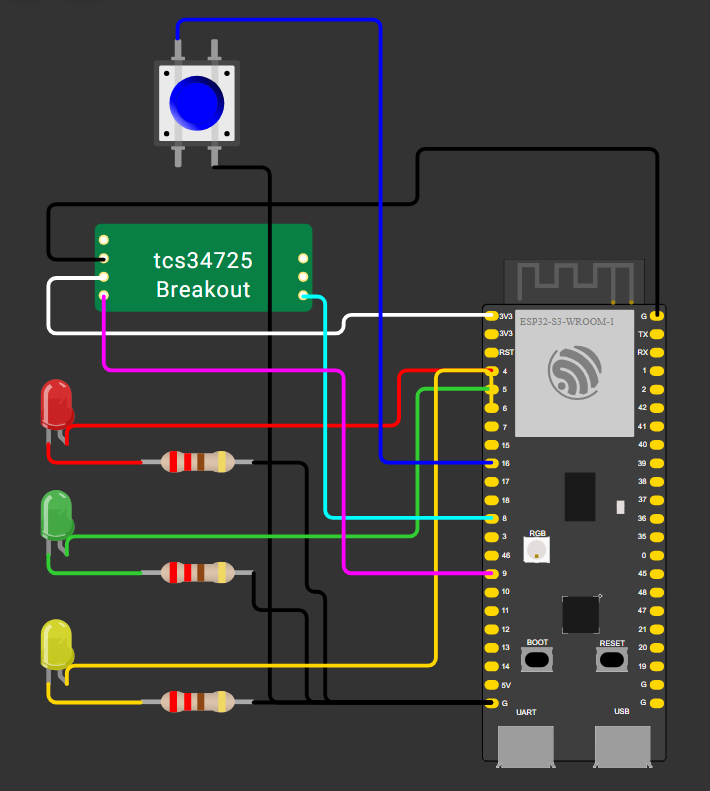


# 4. **Código del servidor Flask.**

http://192.168.101.74:5000

ACTIVACION DEL SERVIDOR: venv\Scripts\activate


```
# ==========================================================
# server.py — Servidor Flask para inferencia de frutas RGB
# ==========================================================
# Este servidor local (Flask) recibe lecturas RGB desde un
# microcontrolador (como ESP32 o ESP8266), ejecuta la inferencia
# en una red neuronal previamente entrenada y retorna la fruta
# reconocida con su nivel de confianza.
#
# Adicionalmente:
#  - Guarda cada lectura en un archivo CSV.
#  - Permite descargar los logs en formato Excel con estilo.
#  - Ofrece una interfaz web de monitoreo en tiempo real.
# ==========================================================

# ==== IMPORTACIONES ====
from flask import Flask, request, jsonify, send_file, render_template_string
import joblib, os, csv, datetime, traceback
import numpy as np
from tensorflow.keras.models import load_model
from openpyxl import Workbook
from openpyxl.styles import Font, PatternFill, Alignment, Border, Side

# ==== CONFIGURACIÓN GENERAL ====
MODEL_PATH = "model.h5"              # Modelo entrenado (red neuronal)
SCALER_PATH = "scaler.pkl"           # Escalador usado en entrenamiento
LE_PATH = "label_encoder.pkl"        # Codificador de etiquetas (frutas)
LOG_FILE = "logs.csv"                # Archivo CSV de registros
PORT = 5000                          # Puerto del servidor Flask
CONFIDENCE_THRESHOLD = 0.60          # Umbral de confianza mínima

app = Flask(__name__)

# ==== CARGA DE MODELO Y OBJETOS ====
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError("❌ No se encontró el modelo entrenado (model.h5).")

# Se cargan los artefactos del entrenamiento
model = load_model(MODEL_PATH)
scaler = joblib.load(SCALER_PATH)
le = joblib.load(LE_PATH)
print(f"✅ Modelo y artefactos cargados correctamente: {MODEL_PATH}")

# ==== CREAR ARCHIVO DE LOGS (si no existe) ====
if not os.path.exists(LOG_FILE):
    with open(LOG_FILE, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["timestamp_utc", "client_id", "R", "G", "B", "predicted", "score"])

# ======================================================
# ENDPOINT 1 → /infer
# ------------------------------------------------------
# Recibe un JSON con formato:
# {
#   "id": "ESP32_01",
#   "rgb": [R, G, B]
# }
# Retorna:
# {
#   "class": "Manzana",
#   "score": 0.95
# }
# ======================================================
@app.route("/infer", methods=["POST"])
def infer():
    try:
        data = request.get_json(force=True)
        client_id = data.get("id", "unknown")
        rgb = data.get("rgb")

        # Validación de datos recibidos
        if not rgb or len(rgb) != 3:
            return jsonify({"error": "El campo 'rgb' debe ser una lista con tres valores [R,G,B]."}), 400

        # Conversión y preprocesamiento
        r, g, b = map(float, rgb)
        X = np.array([[r, g, b]])
        X_scaled = scaler.transform(X)  # Normaliza igual que en el entrenamiento

        # Inferencia
        preds = model.predict(X_scaled, verbose=0)
        idx = int(np.argmax(preds))
        score = float(preds[0, idx])
        label = str(le.inverse_transform([idx])[0])

        # 🔹 Modificación: si la confianza es baja, retorna Banana
        if score < CONFIDENCE_THRESHOLD:
            label = "Banana"

        # Registro con timestamp UTC
        ts = datetime.datetime.utcnow().isoformat() + "Z"
        with open(LOG_FILE, "a", newline="") as f:
            writer = csv.writer(f)
            writer.writerow([ts, client_id, r, g, b, label, round(score, 6)])

        # Log de consola
        print(f"\n🕒 {ts} | 🆔 {client_id} | 🎨 RGB=({r:.1f},{g:.1f},{b:.1f}) → 🤖 {label} ({score:.3f})")
        print("-" * 60)

        # Respuesta JSON al microcontrolador
        return jsonify({"class": label, "score": round(score, 6)}), 200

    except Exception as e:
        traceback.print_exc()
        return jsonify({"error": str(e)}), 500


# ======================================================
# ENDPOINT 2 → /get_logs
# ------------------------------------------------------
# Retorna los últimos 20 registros del log en formato JSON
# ======================================================
@app.route("/get_logs", methods=["GET"])
def get_logs():
    if not os.path.exists(LOG_FILE):
        return jsonify([])

    with open(LOG_FILE, "r") as f:
        reader = csv.DictReader(f)
        data = list(reader)[-20:]  # Últimos 20 registros

    return jsonify(data)


# ======================================================
# ENDPOINT 3 → /monitor
# ------------------------------------------------------
# Interfaz web para monitorear las inferencias en tiempo real
# ======================================================
@app.route("/monitor")
def monitor():
    html = """
    <!DOCTYPE html>
    <html lang="es">
    <head>
        <meta charset="UTF-8">
        <title>Monitor de Inferencias</title>
        <style>
            body { font-family: Arial; background: #f4f6f9; margin: 20px; }
            h1 { color: #2c3e50; }
            table { border-collapse: collapse; width: 100%; background: #fff; box-shadow: 0 0 10px #ccc; }
            th, td { border: 1px solid #ddd; padding: 8px; text-align: center; }
            th { background-color: #4CAF50; color: white; }
            tr:nth-child(even) { background-color: #f2f2f2; }
            button {
                background-color: #3498db; color: white; border: none;
                padding: 10px 15px; border-radius: 5px; cursor: pointer;
            }
            button:hover { background-color: #2980b9; }
        </style>
    </head>
    <body>
        <h1>📡 Monitor de Inferencias</h1>
        <button onclick="window.location.href='/download_excel'">📥 Descargar Excel</button>
        <table id="logTable">
            <thead>
                <tr>
                    <th>Timestamp (UTC)</th>
                    <th>Client ID</th>
                    <th>R</th>
                    <th>G</th>
                    <th>B</th>
                    <th>Predicción</th>
                    <th>Confianza</th>
                </tr>
            </thead>
            <tbody></tbody>
        </table>

        <script>
            async function updateTable() {
                const res = await fetch('/get_logs');
                const data = await res.json();
                const tbody = document.querySelector('#logTable tbody');
                tbody.innerHTML = '';
                data.slice().reverse().forEach(row => {
                    const tr = document.createElement('tr');
                    tr.innerHTML = `
                        <td>${row.timestamp_utc}</td>
                        <td>${row.client_id}</td>
                        <td>${parseFloat(row.R).toFixed(1)}</td>
                        <td>${parseFloat(row.G).toFixed(1)}</td>
                        <td>${parseFloat(row.B).toFixed(1)}</td>
                        <td>${row.predicted}</td>
                        <td>${parseFloat(row.score).toFixed(3)}</td>
                    `;
                    tbody.appendChild(tr);
                });
            }
            updateTable();
            setInterval(updateTable, 2000);
        </script>
    </body>
    </html>
    """
    return render_template_string(html)


# ======================================================
# ENDPOINT 4 → /download_excel
# ------------------------------------------------------
# Convierte los logs CSV a Excel con formato y bordes
# ======================================================
@app.route("/download_excel", methods=["GET"])
def download_excel():
    if not os.path.exists(LOG_FILE):
        return jsonify({"error": "No hay registros disponibles."}), 404

    wb = Workbook()
    ws = wb.active
    ws.title = "Registros de Inferencia"

    # Estilos de encabezado
    header_font = Font(bold=True, color="FFFFFF")
    header_fill = PatternFill("solid", fgColor="4CAF50")
    border = Border(left=Side(style="thin"), right=Side(style="thin"),
                    top=Side(style="thin"), bottom=Side(style="thin"))
    align = Alignment(horizontal="center", vertical="center")

    # Leer CSV
    with open(LOG_FILE, "r") as f:
        reader = csv.reader(f)
        headers = next(reader)
        ws.append(headers)

        for cell in ws[1]:
            cell.font = header_font
            cell.fill = header_fill
            cell.border = border
            cell.alignment = align

        for row in reader:
            ws.append(row)

    # Aplicar formato a todas las celdas
    for row in ws.iter_rows(min_row=2):
        for cell in row:
            cell.border = border
            cell.alignment = align

    # Ajustar ancho de columnas
    for col in ws.columns:
        max_len = max(len(str(cell.value)) for cell in col)
        ws.column_dimensions[col[0].column_letter].width = max_len + 2

    wb.save("logs.xlsx")
    return send_file("logs.xlsx", as_attachment=True,
                     mimetype="application/vnd.openxmlformats-officedocument.spreadsheetml.sheet")


# ======================================================
# EJECUCIÓN DEL SERVIDOR
# ======================================================
if __name__ == "__main__":
    print(f"\n🚀 Servidor Flask corriendo en 0.0.0.0:{PORT}")
    print(f"📡 Endpoint para microcontroladores → http://<IP_LOCAL>:{PORT}/infer")
    print(f"🌐 Panel web → http://<IP_LOCAL>:{PORT}/monitor\n")

    try:
        from waitress import serve
        serve(app, host="0.0.0.0", port=PORT)
    except ImportError:
        app.run(host="0.0.0.0", port=PORT, debug=False)

```




# 5. **Datos con los que se entrena el modelo.**

Este dataset reúne lecturas de color (RGB) obtenidas con un sensor TCS34725 colocadas sobre frutas (las tres clases usadas en el proyecto: Manzana, Limón y Banana).
El objetivo del dataset es servir como base para entrenar un clasificador de color que, a partir de una lectura RGB, identifique la fruta. Está pensado para una demostración de inferencia distribuida: microcontroladores (clientes) toman lecturas, las envían a un servidor que ejecuta la red neuronal y responde la clasificación.

Para mejorar la robuztes al momento de entrenear el modelo se aplicaron 3 tecnicas para aumentar el numero de datos

**- Por qué esta combinación es efectiva**

Ruido y scaling aumentan la robustez local (variaciones naturales).

SMOTE soluciona posibles desbalances y añade ejemplos entre vecinos, ayudando a que el clasificador no se sesgue a clases más frecuentes.

Combinadas, reducen overfitting y mejoran generalización.






# **5.1 Técnicas aplicadas para Data Augmentation**

**1. Ruido Gaussiano (jittering)**

- Qué hace: sumar ruido normal N(0,σ2) sobre cada canal normalizado.

- Por qué: simula variaciones pequeñas del sensor y de la iluminación; evita que la red aprenda exactamente valores discretos.

- Parámetros típicos:
𝜎 = 0.03  a  0.08 σ = 0.03  a  0.08 en datos normalizados; para RGB crudo, usar desviaciones proporcionales.

**2. Escalamiento/Desplazamiento**

- Qué ahce: multiplicar por un factor cercano a 1 (p. ej. uniform(0.95, 1.05)) y/o sumar un pequeño desplazamiento.

- Por qué: simula cambios en intensidad (más/menos luz), cambios en ganancia o distancia.

**3. SMOTE (Synthetic Minority Oversampling Technique)**

- Qué hace: genera puntos sintéticos interpolando entre vecinos de la misma clase en el espacio de características escaladas.

- Por qué: balancea clases cuando alguna fruta tiene menos muestras; produce ejemplos plausibles sin duplicación exacta.


# 6. **Código del entrenamiento de la red neuronal.**




In [ ]:
!pip install tensorflow==2.16.1 joblib scikit-learn pandas matplotlib
import tensorflow as tf
print(tf.__version__)

2.16.1


✅ Dataset cargado correctamente. Dimensiones: (300, 4)
📊 Muestras válidas tras limpieza: 300
🍉 Clases detectadas: ['Banana' 'Limon' 'Manzana']
🔁 Dataset aumentado: 1500 muestras (≈5.0x el original)
⚙️ Dataset balanceado con SMOTE: (1500, 3)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_39 (Dense)                │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,963 (35.01 KB)

 Trainable params: 8,963 (35.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150


75/75 - 6s - 83ms/step - accuracy: 0.5283 - loss: 0.9894 - val_accuracy: 0.6167 - val_loss: 0.8486
Epoch 2/150


75/75 - 0s - 5ms/step - accuracy: 0.7125 - loss: 0.7778 - val_accuracy: 0.8833 - val_loss: 0.6050
Epoch 3/150


75/75 - 0s - 6ms/step - accuracy: 0.7950 - loss: 0.6040 - val_accuracy: 0.8567 - val_loss: 0.4743
Epoch 4/150


75/75 - 0s - 5ms/step - accuracy: 0.8133 - loss: 0.5211 - val_accuracy: 0.8900 - val_loss: 0.4052
Epoch 5/150


75/75 - 0s - 5ms/step - accuracy: 0.8267 - loss: 0.4867 - val_accuracy: 0.8667 - val_loss: 0.3802
Epoch 6/150


75/75 - 0s - 6ms/step - accuracy: 0.8250 - loss: 0.4490 - val_accuracy: 0.8767 - val_loss: 0.3545
Epoch 7/150


75/75 - 0s - 4ms/step - accuracy: 0.8267 - loss: 0.4546 - val_accuracy: 0.8867 - val_loss: 0.3418
Epoch 8/150


75/75 - 0s - 4ms/step - accuracy: 0.8442 - loss: 0.4186 - val_accuracy: 0.8900 - val_loss: 0.3344
Epoch 9/150


75/75 - 0s - 5ms/step - accuracy: 0.8450 - loss: 0.4284 - val_accuracy: 0.8933 - val_loss: 0.3281
Epoch 10/150
75/75 - 0s - 5ms/step - accuracy: 0.8400 - loss: 0.4182 - val_accuracy: 0.8767 - val_loss: 0.3480
Epoch 11/150


75/75 - 0s - 6ms/step - accuracy: 0.8500 - loss: 0.4011 - val_accuracy: 0.9033 - val_loss: 0.3270
Epoch 12/150


75/75 - 1s - 8ms/step - accuracy: 0.8475 - loss: 0.4166 - val_accuracy: 0.8700 - val_loss: 0.3223
Epoch 13/150


75/75 - 0s - 5ms/step - accuracy: 0.8600 - loss: 0.3957 - val_accuracy: 0.8900 - val_loss: 0.3121
Epoch 14/150


75/75 - 0s - 5ms/step - accuracy: 0.8425 - loss: 0.3924 - val_accuracy: 0.8967 - val_loss: 0.3072
Epoch 15/150


75/75 - 0s - 5ms/step - accuracy: 0.8483 - loss: 0.3982 - val_accuracy: 0.8967 - val_loss: 0.3063
Epoch 16/150


75/75 - 0s - 5ms/step - accuracy: 0.8567 - loss: 0.3879 - val_accuracy: 0.8967 - val_loss: 0.3014
Epoch 17/150
75/75 - 0s - 5ms/step - accuracy: 0.8675 - loss: 0.3770 - val_accuracy: 0.8933 - val_loss: 0.3027
Epoch 18/150
75/75 - 0s - 4ms/step - accuracy: 0.8550 - loss: 0.3781 - val_accuracy: 0.8933 - val_loss: 0.3043
Epoch 19/150
75/75 - 0s - 5ms/step - accuracy: 0.8475 - loss: 0.3857 - val_accuracy: 0.8967 - val_loss: 0.3148
Epoch 20/150


75/75 - 0s - 5ms/step - accuracy: 0.8542 - loss: 0.3863 - val_accuracy: 0.8967 - val_loss: 0.2941
Epoch 21/150
75/75 - 0s - 4ms/step - accuracy: 0.8617 - loss: 0.3741 - val_accuracy: 0.8967 - val_loss: 0.2971
Epoch 22/150
75/75 - 0s - 4ms/step - accuracy: 0.8542 - loss: 0.3837 - val_accuracy: 0.8933 - val_loss: 0.2962
Epoch 23/150
75/75 - 0s - 5ms/step - accuracy: 0.8558 - loss: 0.3634 - val_accuracy: 0.8933 - val_loss: 0.3057
Epoch 24/150
75/75 - 0s - 4ms/step - accuracy: 0.8642 - loss: 0.3736 - val_accuracy: 0.8800 - val_loss: 0.2958
Epoch 25/150
75/75 - 0s - 5ms/step - accuracy: 0.8592 - loss: 0.3837 - val_accuracy: 0.9067 - val_loss: 0.3099
Epoch 26/150
75/75 - 0s - 5ms/step - accuracy: 0.8650 - loss: 0.3641 - val_accuracy: 0.8833 - val_loss: 0.2965
Epoch 27/150


75/75 - 0s - 6ms/step - accuracy: 0.8625 - loss: 0.3648 - val_accuracy: 0.9000 - val_loss: 0.2916
Epoch 28/150
75/75 - 1s - 8ms/step - accuracy: 0.8492 - loss: 0.3887 - val_accuracy: 0.8833 - val_loss: 0.2925
Epoch 29/150


75/75 - 1s - 9ms/step - accuracy: 0.8608 - loss: 0.3576 - val_accuracy: 0.9000 - val_loss: 0.2884
Epoch 30/150
75/75 - 1s - 7ms/step - accuracy: 0.8508 - loss: 0.3684 - val_accuracy: 0.8933 - val_loss: 0.2955
Epoch 31/150
75/75 - 1s - 8ms/step - accuracy: 0.8608 - loss: 0.3702 - val_accuracy: 0.9100 - val_loss: 0.2986
Epoch 32/150
75/75 - 1s - 9ms/step - accuracy: 0.8575 - loss: 0.3645 - val_accuracy: 0.9000 - val_loss: 0.2991
Epoch 33/150


75/75 - 0s - 5ms/step - accuracy: 0.8592 - loss: 0.3719 - val_accuracy: 0.8967 - val_loss: 0.2867
Epoch 34/150
75/75 - 0s - 5ms/step - accuracy: 0.8600 - loss: 0.3664 - val_accuracy: 0.9033 - val_loss: 0.2896
Epoch 35/150
75/75 - 0s - 5ms/step - accuracy: 0.8683 - loss: 0.3570 - val_accuracy: 0.8967 - val_loss: 0.2922
Epoch 36/150
75/75 - 0s - 5ms/step - accuracy: 0.8542 - loss: 0.3774 - val_accuracy: 0.8867 - val_loss: 0.3054
Epoch 37/150
75/75 - 0s - 5ms/step - accuracy: 0.8683 - loss: 0.3738 - val_accuracy: 0.8867 - val_loss: 0.2984
Epoch 38/150
75/75 - 0s - 4ms/step - accuracy: 0.8567 - loss: 0.3681 - val_accuracy: 0.8900 - val_loss: 0.2914
Epoch 39/150
75/75 - 0s - 5ms/step - accuracy: 0.8592 - loss: 0.3639 - val_accuracy: 0.9000 - val_loss: 0.2890
Epoch 40/150
75/75 - 0s - 5ms/step - accuracy: 0.8575 - loss: 0.3645 - val_accuracy: 0.8933 - val_loss: 0.3169
Epoch 41/150
75/75 - 0s - 5ms/step - accuracy: 0.8675 - loss: 0.3624 - val_accuracy: 0.8933 - val_loss: 0.2966
Epoch 42/150
7

75/75 - 0s - 5ms/step - accuracy: 0.8617 - loss: 0.3675 - val_accuracy: 0.8967 - val_loss: 0.2798
Epoch 44/150
75/75 - 0s - 4ms/step - accuracy: 0.8567 - loss: 0.3576 - val_accuracy: 0.8867 - val_loss: 0.2869
Epoch 45/150
75/75 - 0s - 5ms/step - accuracy: 0.8617 - loss: 0.3566 - val_accuracy: 0.8967 - val_loss: 0.3036
Epoch 46/150
75/75 - 0s - 5ms/step - accuracy: 0.8650 - loss: 0.3589 - val_accuracy: 0.8933 - val_loss: 0.2848
Epoch 47/150
75/75 - 0s - 4ms/step - accuracy: 0.8625 - loss: 0.3579 - val_accuracy: 0.8967 - val_loss: 0.2800
Epoch 48/150
75/75 - 0s - 4ms/step - accuracy: 0.8625 - loss: 0.3580 - val_accuracy: 0.8967 - val_loss: 0.2971
Epoch 49/150
75/75 - 0s - 5ms/step - accuracy: 0.8608 - loss: 0.3579 - val_accuracy: 0.9000 - val_loss: 0.2846
Epoch 50/150
75/75 - 0s - 4ms/step - accuracy: 0.8617 - loss: 0.3627 - val_accuracy: 0.8900 - val_loss: 0.2850
Epoch 51/150
75/75 - 0s - 4ms/step - accuracy: 0.8642 - loss: 0.3503 - val_accuracy: 0.8767 - val_loss: 0.2878
Epoch 52/150
7

75/75 - 0s - 5ms/step - accuracy: 0.8583 - loss: 0.3522 - val_accuracy: 0.8833 - val_loss: 0.2758
Epoch 56/150
75/75 - 0s - 5ms/step - accuracy: 0.8675 - loss: 0.3606 - val_accuracy: 0.8933 - val_loss: 0.3118
Epoch 57/150
75/75 - 0s - 5ms/step - accuracy: 0.8692 - loss: 0.3451 - val_accuracy: 0.8833 - val_loss: 0.2781
Epoch 58/150
75/75 - 0s - 5ms/step - accuracy: 0.8683 - loss: 0.3436 - val_accuracy: 0.8800 - val_loss: 0.2878
Epoch 59/150
75/75 - 0s - 5ms/step - accuracy: 0.8600 - loss: 0.3507 - val_accuracy: 0.9000 - val_loss: 0.2804
Epoch 60/150
75/75 - 1s - 8ms/step - accuracy: 0.8675 - loss: 0.3473 - val_accuracy: 0.8833 - val_loss: 0.2808
Epoch 61/150
75/75 - 1s - 16ms/step - accuracy: 0.8583 - loss: 0.3612 - val_accuracy: 0.8967 - val_loss: 0.2978
Epoch 62/150


75/75 - 1s - 8ms/step - accuracy: 0.8633 - loss: 0.3469 - val_accuracy: 0.9100 - val_loss: 0.2743
Epoch 63/150
75/75 - 1s - 7ms/step - accuracy: 0.8708 - loss: 0.3439 - val_accuracy: 0.8867 - val_loss: 0.2784
Epoch 64/150
75/75 - 0s - 4ms/step - accuracy: 0.8667 - loss: 0.3481 - val_accuracy: 0.9000 - val_loss: 0.2798
Epoch 65/150
75/75 - 0s - 4ms/step - accuracy: 0.8592 - loss: 0.3573 - val_accuracy: 0.8900 - val_loss: 0.2813
Epoch 66/150
75/75 - 1s - 8ms/step - accuracy: 0.8692 - loss: 0.3523 - val_accuracy: 0.8833 - val_loss: 0.2810
Epoch 67/150
75/75 - 1s - 8ms/step - accuracy: 0.8617 - loss: 0.3505 - val_accuracy: 0.8833 - val_loss: 0.2834
Epoch 68/150
75/75 - 0s - 4ms/step - accuracy: 0.8692 - loss: 0.3532 - val_accuracy: 0.9033 - val_loss: 0.2916
Epoch 69/150
75/75 - 0s - 4ms/step - accuracy: 0.8633 - loss: 0.3505 - val_accuracy: 0.8800 - val_loss: 0.2891
Epoch 70/150
75/75 - 0s - 4ms/step - accuracy: 0.8658 - loss: 0.3541 - val_accuracy: 0.9067 - val_loss: 0.2792
Epoch 71/150
7

75/75 - 0s - 5ms/step - accuracy: 0.8608 - loss: 0.3413 - val_accuracy: 0.8933 - val_loss: 0.2727
Epoch 81/150
75/75 - 0s - 5ms/step - accuracy: 0.8667 - loss: 0.3492 - val_accuracy: 0.9033 - val_loss: 0.2776
Epoch 82/150
75/75 - 0s - 4ms/step - accuracy: 0.8642 - loss: 0.3501 - val_accuracy: 0.9000 - val_loss: 0.2938
Epoch 83/150
75/75 - 0s - 5ms/step - accuracy: 0.8567 - loss: 0.3429 - val_accuracy: 0.8867 - val_loss: 0.2820
Epoch 84/150
75/75 - 0s - 4ms/step - accuracy: 0.8658 - loss: 0.3417 - val_accuracy: 0.8867 - val_loss: 0.2728
Epoch 85/150
75/75 - 0s - 5ms/step - accuracy: 0.8750 - loss: 0.3328 - val_accuracy: 0.9100 - val_loss: 0.2760
Epoch 86/150
75/75 - 0s - 5ms/step - accuracy: 0.8700 - loss: 0.3326 - val_accuracy: 0.8767 - val_loss: 0.2779
Epoch 87/150
75/75 - 0s - 4ms/step - accuracy: 0.8708 - loss: 0.3485 - val_accuracy: 0.8900 - val_loss: 0.2757
Epoch 88/150
75/75 - 0s - 4ms/step - accuracy: 0.8658 - loss: 0.3390 - val_accuracy: 0.8933 - val_loss: 0.2732
Epoch 89/150
7

75/75 - 1s - 10ms/step - accuracy: 0.8600 - loss: 0.3586 - val_accuracy: 0.9067 - val_loss: 0.2704
Epoch 94/150
75/75 - 1s - 8ms/step - accuracy: 0.8708 - loss: 0.3302 - val_accuracy: 0.9033 - val_loss: 0.2745
Epoch 95/150
75/75 - 0s - 7ms/step - accuracy: 0.8750 - loss: 0.3331 - val_accuracy: 0.9033 - val_loss: 0.2724
Epoch 96/150
75/75 - 0s - 6ms/step - accuracy: 0.8700 - loss: 0.3492 - val_accuracy: 0.9033 - val_loss: 0.2817
Epoch 97/150
75/75 - 1s - 8ms/step - accuracy: 0.8617 - loss: 0.3497 - val_accuracy: 0.8867 - val_loss: 0.2846
Epoch 98/150
75/75 - 0s - 4ms/step - accuracy: 0.8608 - loss: 0.3378 - val_accuracy: 0.9000 - val_loss: 0.2788
Epoch 99/150
75/75 - 0s - 4ms/step - accuracy: 0.8742 - loss: 0.3366 - val_accuracy: 0.8833 - val_loss: 0.2743
Epoch 100/150
75/75 - 0s - 5ms/step - accuracy: 0.8667 - loss: 0.3431 - val_accuracy: 0.8867 - val_loss: 0.2767
Epoch 101/150
75/75 - 0s - 4ms/step - accuracy: 0.8750 - loss: 0.3287 - val_accuracy: 0.9067 - val_loss: 0.2809
Epoch 102/1

<Figure size 600x500 with 0 Axes>

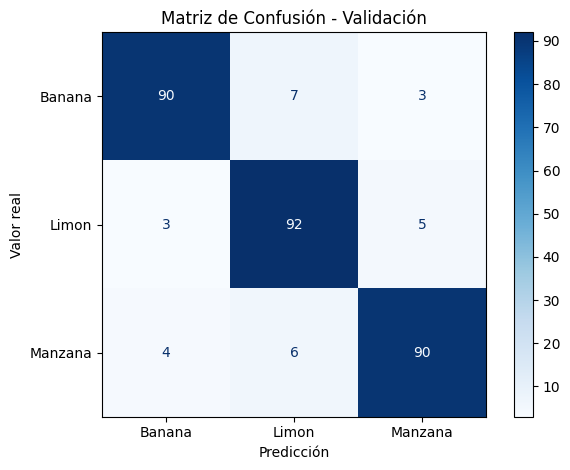

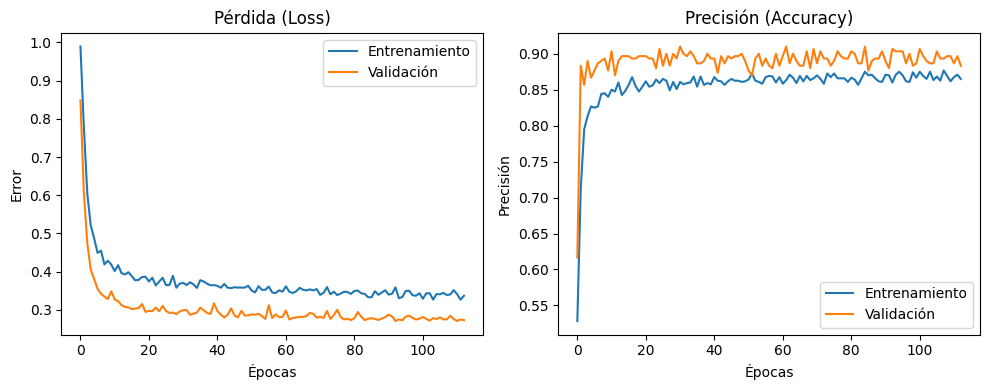

In [ ]:
"""
==============================================================
ENTRENAMIENTO DE RED NEURONAL PARA CLASIFICACIÓN DE FRUTAS RGB
==============================================================
Con AUMENTO DE DATOS (Ruido Gaussiano + Escalamiento + SMOTE)
"""

# ==== LIBRERÍAS ====
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib
from imblearn.over_sampling import SMOTE

# ==== CONFIGURACIÓN ====
CSV_PATH = "Dataset_Frutas.csv"
MODEL_OUT = "model.h5"
SCALER_OUT = "scaler.pkl"
LE_OUT = "label_encoder.pkl"
RANDOM_STATE = 42
TEST_SIZE = 0.2

assert os.path.exists(CSV_PATH), f"❌ No existe {CSV_PATH}"

# ==== 1) CARGA DE DATOS ====
df = pd.read_csv(CSV_PATH)
print("✅ Dataset cargado correctamente. Dimensiones:", df.shape)

expected = ['R', 'G', 'B', 'Fruta']
if not all(c in df.columns for c in expected):
    raise ValueError(f"⚠️ El CSV debe contener las columnas: {expected}\nEncontradas: {list(df.columns)}")

# ==== 2) LIMPIEZA DE DATOS ====
df = df.dropna()
df[['R', 'G', 'B']] = df[['R', 'G', 'B']].clip(lower=0)
print(f"📊 Muestras válidas tras limpieza: {len(df)}")

# ==== 3) SEPARACIÓN DE VARIABLES ====
X = df[['R', 'G', 'B']].values.astype(float)
y = df['Fruta'].values.astype(str)

# ==== 4) CODIFICACIÓN DE ETIQUETAS ====
le = LabelEncoder()
y_enc = le.fit_transform(y)
classes = le.classes_
print("🍉 Clases detectadas:", classes)

# ==== 5) NORMALIZACIÓN ====
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

# ============================================================
# 🔄 AUMENTO DE DATOS (DATA AUGMENTATION)
# ============================================================

def add_gaussian_noise(X, std_factor=0.05):
    noise = np.random.normal(0, std_factor, X.shape)
    return np.clip(X + noise, -3, 3)

def apply_scaling_shift(X, scale_range=0.1, shift_range=0.1):
    scale = np.random.uniform(1 - scale_range, 1 + scale_range, X.shape)
    shift = np.random.uniform(-shift_range, shift_range, X.shape)
    return np.clip(X * scale + shift, -3, 3)

# Se generan varias versiones aumentadas (sin tocar el dataset original)
X_aug = [Xs]
y_aug = [y_enc]

for _ in range(2):  # dos copias con ruido
    X_aug.append(add_gaussian_noise(Xs))
    y_aug.append(y_enc)

for _ in range(2):  # dos copias con escalamiento
    X_aug.append(apply_scaling_shift(Xs))
    y_aug.append(y_enc)

# Concatenar todas las versiones aumentadas
X_total = np.vstack(X_aug)
y_total = np.hstack(y_aug)

print(f"🔁 Dataset aumentado: {X_total.shape[0]} muestras (≈{X_total.shape[0] / len(df):.1f}x el original)")

# ==== SMOTE ====
smote = SMOTE(random_state=RANDOM_STATE)
X_res, y_res = smote.fit_resample(X_total, y_total)
print(f"⚙️ Dataset balanceado con SMOTE: {X_res.shape}")

# ==== 6) DIVISIÓN EN TRAIN Y VALIDACIÓN ====
X_train, X_val, y_train, y_val = train_test_split(
    X_res, y_res, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_res
)

# ==== 7) CONVERSIÓN A ONE-HOT ====
from tensorflow.keras.utils import to_categorical
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)

# ==== 8) DISEÑO DE LA RED NEURONAL ====
input_dim = X_train.shape[1]
n_classes = y_train_cat.shape[1]

model = Sequential([
    Dense(128, input_shape=(input_dim,), activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(n_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# ==== 9) CALLBACKS ====
es = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
mc = ModelCheckpoint(MODEL_OUT, save_best_only=True, monitor='val_loss')

# ==== 10) ENTRENAMIENTO ====
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=150,
    batch_size=16,
    callbacks=[es, mc],
    verbose=2
)

# ==== 11) EVALUACIÓN ====
val_loss, val_acc = model.evaluate(X_val, y_val_cat, verbose=0)
print(f"\n📈 Resultados finales: Loss={val_loss:.4f} | Accuracy={val_acc:.4f}")

# ==== 12) REPORTE DETALLADO ====
y_pred_prob = model.predict(X_val)
y_pred = np.argmax(y_pred_prob, axis=1)
print("\n🧾 Reporte de Clasificación:\n", classification_report(y_val, y_pred, target_names=classes))

# ==== 13) MATRIZ DE CONFUSIÓN ====
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title("Matriz de Confusión - Validación")
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
print("✅ Matriz de confusión guardada como confusion_matrix.png")

# ==== 14) GUARDADO DE MODELO Y OBJETOS ====
joblib.dump(scaler, SCALER_OUT)
joblib.dump(le, LE_OUT)
print(f"\n💾 Archivos guardados:\n - Modelo: {MODEL_OUT}\n - Scaler: {SCALER_OUT}\n - LabelEncoder: {LE_OUT}")

# ==== 15) GRÁFICAS DE ENTRENAMIENTO ====
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida (Loss)')
plt.xlabel('Épocas')
plt.ylabel('Error')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión (Accuracy)')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.tight_layout()
plt.savefig("training_curves.png")
print("📊 Gráficas guardadas: training_curves.png y confusion_matrix.png")

print("\n✅ Entrenamiento completado exitosamente con aumento de datos.")
